# 0. Load all dependencies

In [15]:

# Importing some useful packages

from importlib import reload
from matplotlib.patches import Polygon

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import os
import glob
import pickle
import cv2

sys.path.append("../../") # go to parent dir

# Visualizations will be shown in the notebook:

%matplotlib inline


# Import local deps

import src.helpers.lineRegressorWithMemory as LRM
import src.helpers.imageProcessing as IP
import src.helpers.plot as P
import src.helpers.cameraCalibration as C
import src.helpers.laneFinder as LF
import src.helpers.imagePreprocessingPipeline as IPP


if 'src.helpers.imageProcessing' in sys.modules:
    print("Reloading Modules...")
    
    reload(LRM)
    reload(IP)
    reload(P)
    reload(C)
    reload(LF)
    reload(IPP)

    print("\nModules Reloaded!")


Reloading Modules...

Modules Reloaded!


# 1. Load all test images in RGB and preprocess them

Available images:

../../input/images\001 - Yellow Straight.jpg
../../input/images\002 - White Straight.jpg
../../input/images\003 - Yellow Curve Deer Sign.jpg
../../input/images\004 - Yellow Curve.jpg
../../input/images\005 - Stripe Far.jpg
../../input/images\006 - Stripe Next.jpg
../../input/images\007 - Stripe Start.jpg
../../input/images\008 - Stripe On.jpg
../../input/images\009 - Road Sign.jpg
../../input/images\010 - Harder S Lane Line.jpg
../../input/images\011 - Harder Motorbike.jpg
../../input/images\012 - Harder Covered Lane Line.jpg
../../input/images\013 - Harder Reflexion.jpg
../../input/images\014 - Harder Sharp Turn.jpg
../../input/images\015 - Harder Sharp Turn Sunlight.jpg



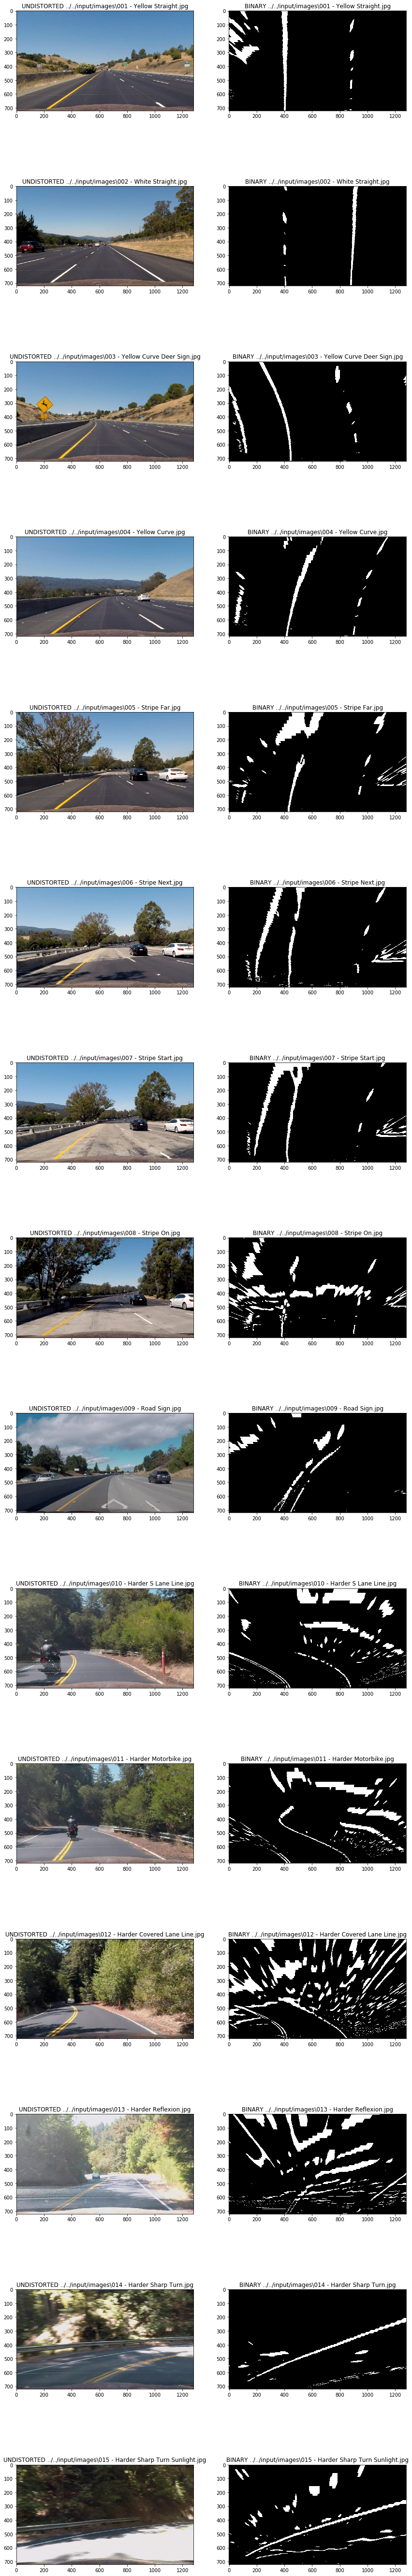

In [17]:

# Get all the test images

imagesNames = glob.glob("../../input/images/*.jpg")
# imagesNames = ["005 - Yellow Curve.jpg", "007 - Challenge Shadow.jpg"]


print("Available images:\n")

for imageName in imagesNames: print(imageName)

print("")


# Load all images in RGB

imagesOriginal = list(map(lambda imageName: mpimg.imread(imageName), imagesNames))


# Get image count & dimensions

anyImage = imagesOriginal[0]

WIDTH = anyImage.shape[1]
HEIGHT = anyImage.shape[0]
    
imagesCount = len(imagesNames)


# Load camera calibration

data = pickle.load(open('../../output/data/calibration.p', 'rb'))
mtx = data["mtx"]
dist = data["dist"]


# Calculate perpective transform matrixs

MIDDLE = WIDTH // 2
H_MARGIN_TOP = 50
H_MARGIN_BOTTOM = 215
CORRECTION = 15
DST_MARGIN_H = 400
DST_MARGIN_TOP = 100

src = np.array([
    (MIDDLE - H_MARGIN_TOP + CORRECTION - 10, 450),
    (MIDDLE + H_MARGIN_TOP + CORRECTION - 22, 450), 
    (WIDTH - H_MARGIN_BOTTOM + CORRECTION - 5, 700), 
    (H_MARGIN_BOTTOM + CORRECTION, 700)
], np.float32)

dst = np.array([
    (DST_MARGIN_H, DST_MARGIN_TOP),
    (WIDTH - DST_MARGIN_H, DST_MARGIN_TOP),
    (WIDTH - DST_MARGIN_H, HEIGHT),
    (DST_MARGIN_H, HEIGHT)
], np.float32)

M, Minv = C.getM(src, dst)


# Preprocess all images

imgsUndistorted = [C.undistort(img, mtx, dist) for img in imagesOriginal]
imgsBinaries = [IPP.pipeline(img, M) for img in imgsUndistorted]


# Get a grid

gs = P.getGrid(len(imagesNames), 2) 

for i in range(imagesCount): 
    imageName = imagesNames[i]
    imgUndistorted = imgsUndistorted[i]
    imgBinary = imgsBinaries[i]
    
    ax = plt.subplot(gs[i, 0])
    ax.imshow(imgUndistorted)
    ax.set_title("UNDISTORTED %s" % imageName)
    
    ax = plt.subplot(gs[i, 1])
    ax.imshow(imgBinary, cmap="gray")
    ax.set_title("BINARY %s" % imageName)


# 2. Sliding window

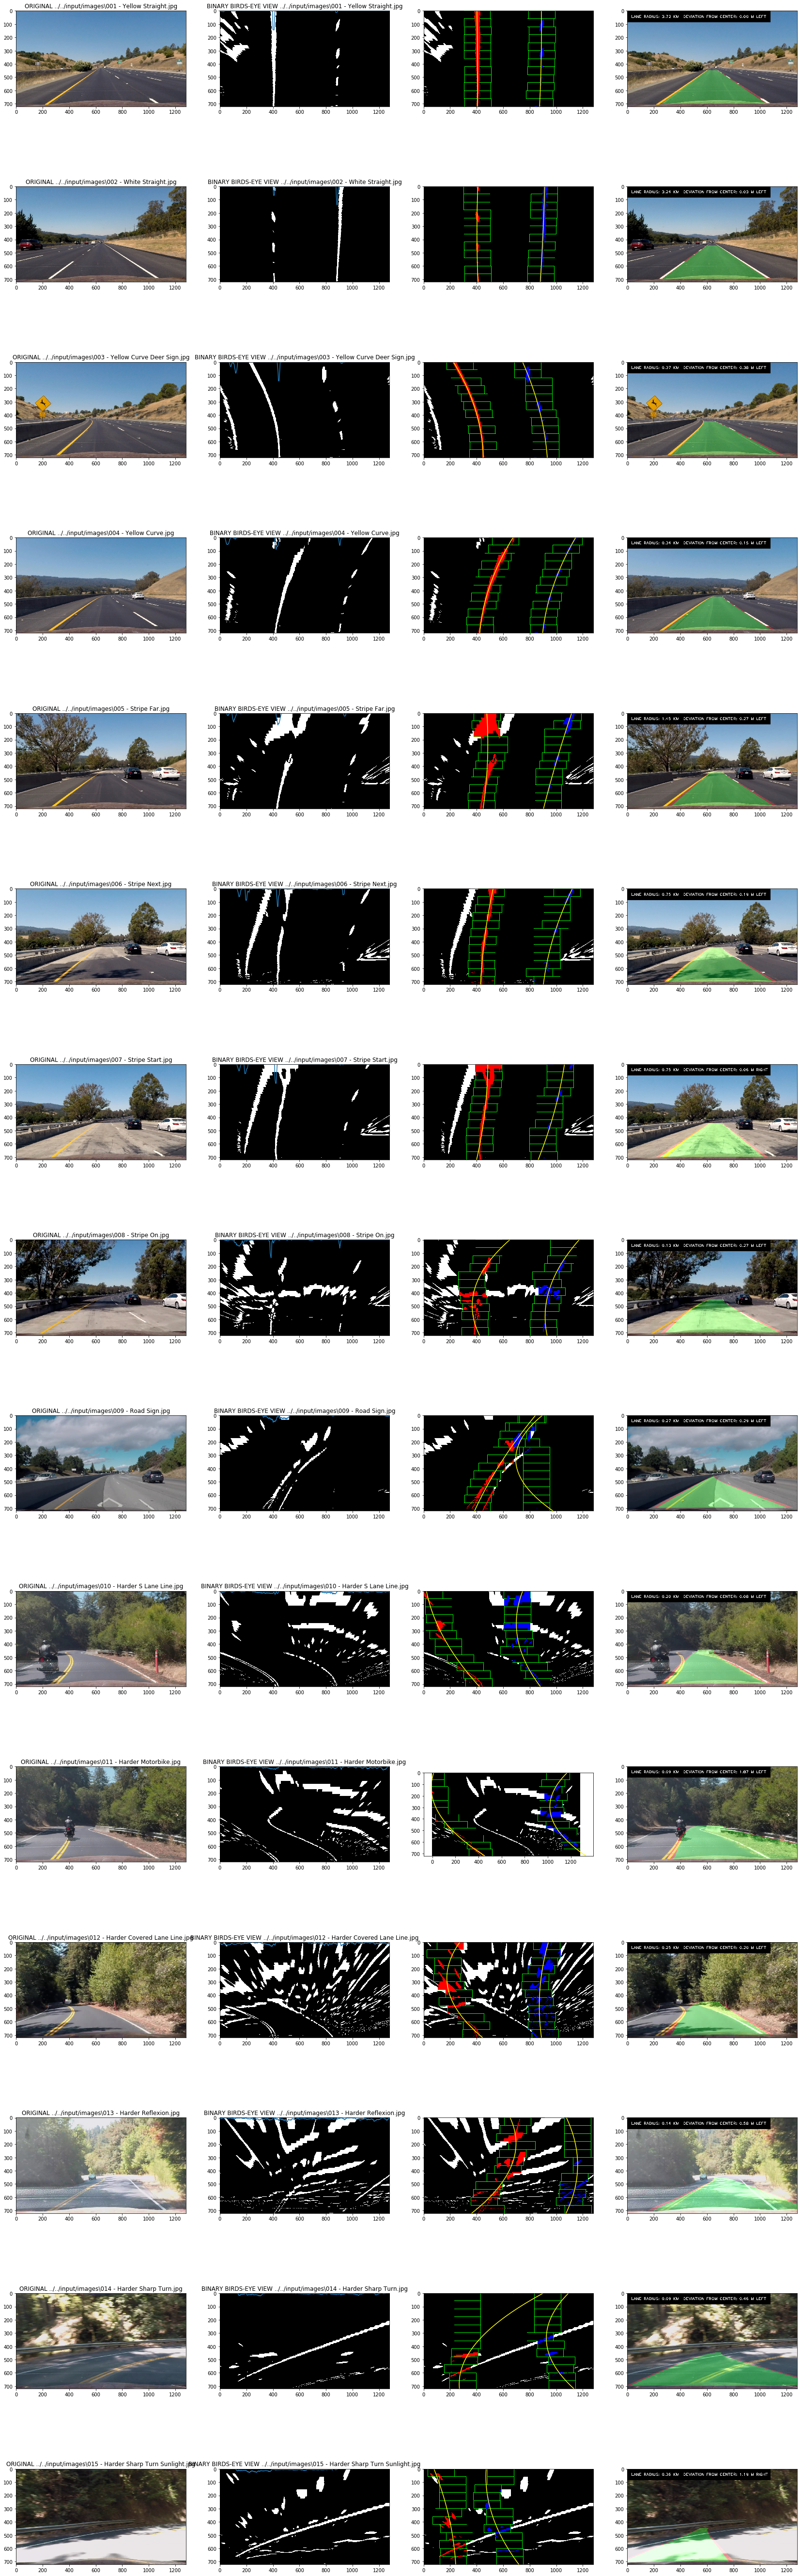

In [21]:

# TODO: Filter out laplacin in dark areas!

# TODO: Weight polyfit?

gs = P.getGrid(len(imagesNames), 4) 

for i in range(imagesCount): 
    imageName = imagesNames[i]
    imgUndistorted = imgsUndistorted[i]
    imgBinary = imgsBinaries[i]
    
    # Original:
    ax = plt.subplot(gs[i, 0])
    ax.imshow(imgUndistorted)
    ax.set_title("ORIGINAL %s" % imageName)
    
    # Birds-eye view:
    ax = plt.subplot(gs[i, 1])
    ax.imshow(imgBinary, cmap='gray')
    ax.set_title("BINARY BIRDS-EYE VIEW %s" % imageName)
    
    # Overlay:
    histogram = np.sum(imgBinary[-HEIGHT//5:,:], axis=0)
    ax.plot(histogram, alpha=1)
    
    # Fit:
    coefs_L, coefs_R, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img, \
        leftx, rightx, lefty, righty = LF.getFirstTime(imgBinary, hist_slice=5, nwindows = 12, minpix = 60, margin = 100)

    # Generate x and y values for plotting
    ploty = np.linspace(0, HEIGHT - 1, HEIGHT)
    left_fitx = np.polyval(coefs_L, ploty)
    right_fitx = np.polyval(coefs_R, ploty)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ax = plt.subplot(gs[i, 2])
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    # ax.xlim(0, 1280)
    # ax.ylim(720, 0)
    
    # Overlay:
    
    rad_m_L, rad_m_R = LF.getRadius(ploty, leftx, rightx, lefty, righty)
    deviation_px, deviation_m = LF.getDistanceFromCenter(coefs_L, coefs_R, MIDDLE, HEIGHT, 3.7/500)
    
    ax = plt.subplot(gs[i, 3])
    ax.imshow(LF.drawOverlayLane(imgBinary, imgUndistorted,
         Minv, left_fitx, right_fitx, ploty, (WIDTH, HEIGHT), (rad_m_L + rad_m_R) / 2, deviation_m))


In turns, do the hist of a smaller area (check variance maybe)

Update the boxes stuff  to avoid going up when it gets to the side and try the convolutions version


# 3. Skip the sliding windows & calculate curvature and distance from center

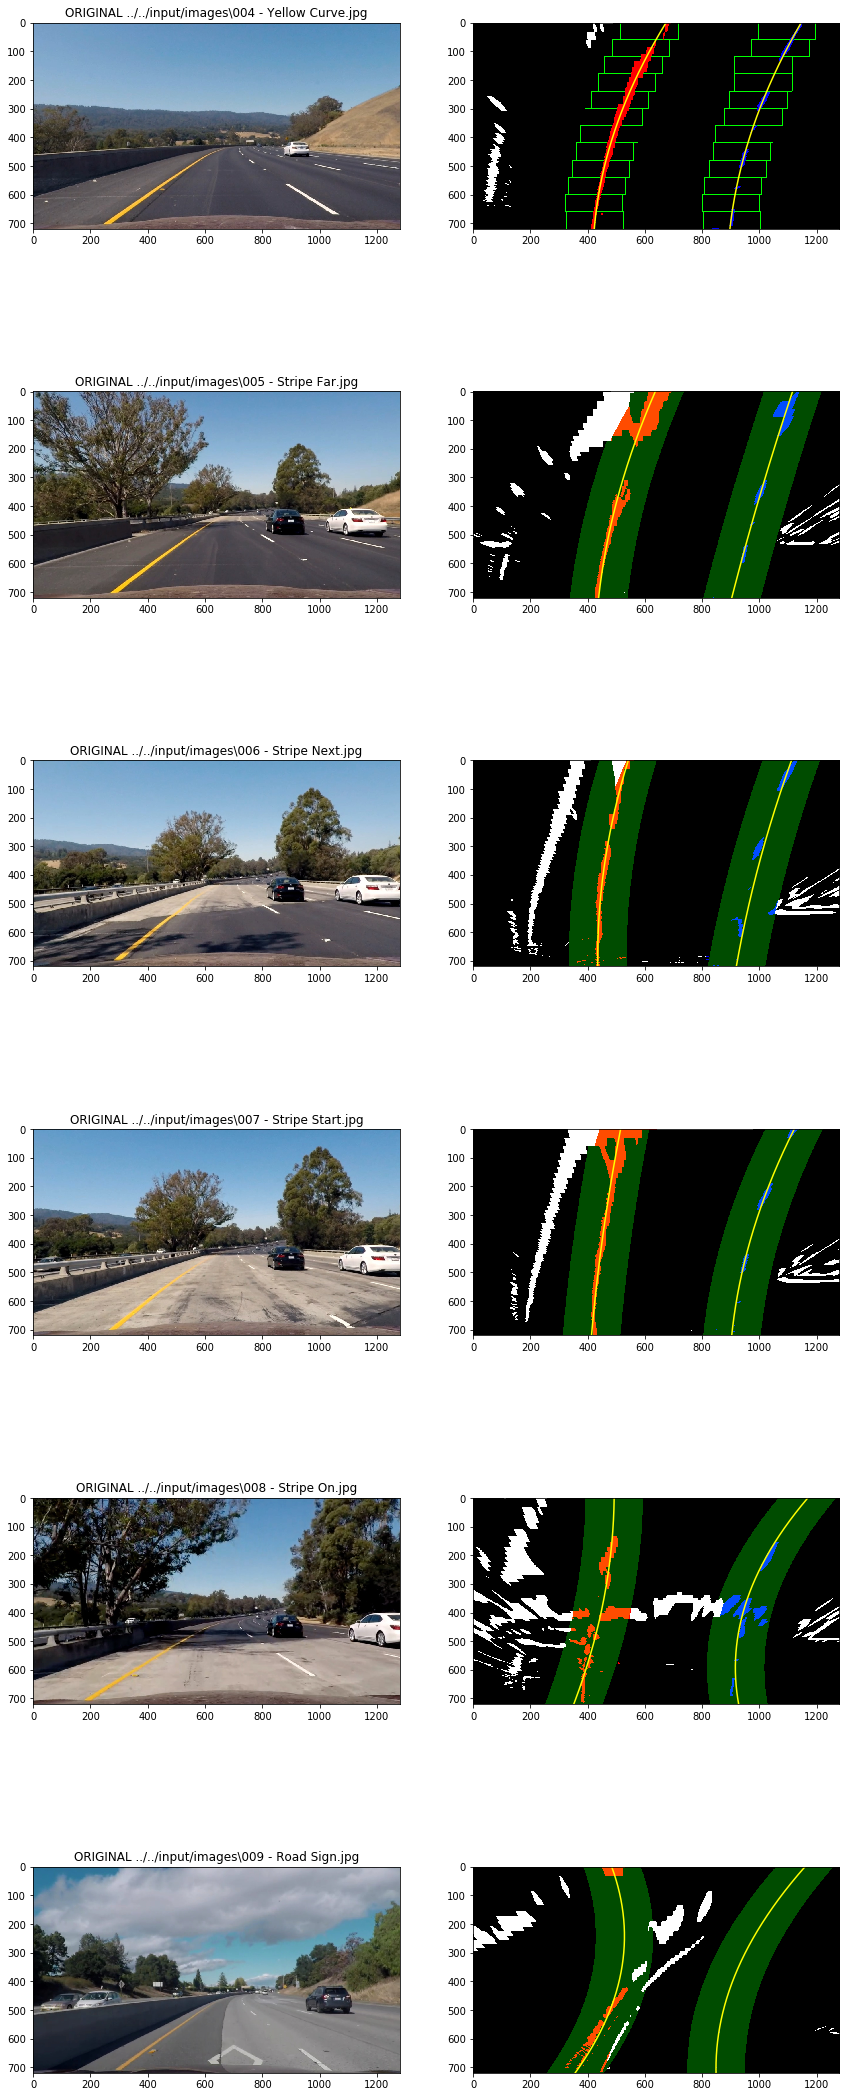

In [25]:

# These are part of a sequence:
indexes = [3, 4, 5, 6, 7, 8]
firstIndex = indexes[0]

gs = P.getGrid(len(indexes), 2) 
gridIndex = 1

# Plot the first one using the window search: 
imageName = imagesNames[firstIndex]
imgBinary = imgsBinaries[firstIndex]
    
ax = plt.subplot(gs[0, 0])
ax.imshow(imgsUndistorted[firstIndex])
ax.set_title("ORIGINAL %s" % imageName)

coefs_L, coefs_R, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img, \
    leftx, rightx, lefty, righty = LF.getFirstTime(imgBinary, hist_slice=5, nwindows = 12, minpix = 60, margin = 100)

# Generate x and y values for plotting
ploty = np.linspace(0, HEIGHT - 1, HEIGHT)
left_fitx = np.polyval(coefs_L, ploty)
right_fitx = np.polyval(coefs_R, ploty)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

ax = plt.subplot(gs[0, 1])
ax.imshow(out_img)
ax.plot(left_fitx, ploty, color='yellow')
ax.plot(right_fitx, ploty, color='yellow')

for i in indexes[1:]: 
    imageName = imagesNames[i]
    imgBinary = imgsBinaries[i]
    
    ax = plt.subplot(gs[gridIndex, 0])
    ax.imshow(imgsUndistorted[i])
    ax.set_title("ORIGINAL %s" % imageName)

    # Fit 1:
    coefs_L, coefs_R, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, \
        out_img, ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty = LF.getFromRegion(imgBinary, coefs_L, coefs_R)

    ax = plt.subplot(gs[gridIndex, 1])
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    # ax.xlim(0, 1280)
    # ax.ylim(720, 0)

    gridIndex += 1

NOTE: Sliding window with convolutions not implemented. 